In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from env import get_db_url

# Acquire data from SQL database
    - rename columns from acquire phase
    - only show Single family residental which is ID 261
    - I don't want to see beds and baths with zero
    - I only want transaction dates in 2017

In [2]:
# sql query from zillow database:

sql = """
SELECT bedroomcnt AS bedrooms, bathroomcnt AS bathrooms, `calculatedfinishedsquarefeet` AS square_feet,  
`lotsizesquarefeet` AS lot_size, poolcnt AS pool, `regionidzip` AS zip_code, yearbuilt AS year_built, latitude, 
longitude, fips, `taxvaluedollarcnt` AS assessed_value, `taxamount` AS tax_value, transactiondate AS transaction_date
FROM properties_2017
JOIN predictions_2017 USING (id)
WHERE propertylandusetypeid = 261 AND bedroomcnt > 0 AND bathroomcnt > 0
AND transactiondate >= '2017-01-01' AND transactiondate <= '2017-12-32'
"""

df = pd.read_sql(sql, get_db_url("zillow"))
df.head()

,bedrooms,bathrooms,square_feet,lot_size,pool,zip_code,year_built,latitude,longitude,fips,assessed_value,tax_value,transaction_date
0,4.0,2.0,3633.0,9826.0,NaN,97329.0,2005.0,34560018.0,-118169806.0,6037.0,296425.0,6941.39,2017-01-02
1,3.0,4.0,1620.0,NaN,NaN,96047.0,2011.0,33996200.0,-118438000.0,6037.0,847770.0,10244.94,2017-01-02
2,3.0,2.0,2077.0,6490.0,NaN,96152.0,1926.0,34012977.0,-118479243.0,6037.0,646760.0,7924.68,2017-01-02
3,3.0,1.0,1244.0,6021.0,NaN,96201.0,1950.0,33953559.0,-118083855.0,6037.0,169471.0,2532.88,2017-01-03
4,3.0,2.0,1300.0,4917.0,NaN,96193.0,1950.0,33897134.0,-118102953.0,6037.0,233266.0,3110.99,2017-01-03


In [3]:
# Shows me how many rows and columns
df.shape

(55692, 13)

In [4]:
# Lists the columns
df.columns

Index(['bedrooms', 'bathrooms', 'square_feet', 'lot_size', 'pool', 'zip_code',
       'year_built', 'latitude', 'longitude', 'fips', 'assessed_value',
       'tax_value', 'transaction_date'],
      dtype='object')

In [5]:
# shows the data types for columns
df.dtypes

bedrooms            float64
bathrooms           float64
square_feet         float64
lot_size            float64
pool                float64
zip_code            float64
year_built          float64
latitude            float64
longitude           float64
fips                float64
assessed_value      float64
tax_value           float64
transaction_date     object
dtype: object

### Will have to convert dtypes to integers in prepare

In [6]:
# Shows me how many nulls are in each column
df.isnull().sum()

bedrooms                0
bathrooms               0
square_feet             5
lot_size              300
pool                44757
zip_code               64
year_built             29
latitude                0
longitude               0
fips                    0
assessed_value          2
tax_value              72
transaction_date        0
dtype: int64

In [7]:
# List all the columns, how many nulls are in each column, the percentage of nulls, and min and max of each column.
for col in df.columns:
    print(col)
    print(df[col].isnull().sum())
    print((df[col].isnull().sum()/55692)*100)
    print(df[col].min())
    print(df[col].max())

bedrooms
0
0.0
1.0
25.0
bathrooms
0
0.0
1.0
20.0
square_feet
5
0.008977950154420744
320.0
26345.0
lot_size
300
0.5386770092652445
500.0
6971010.0
pool
44757
80.36522301228185
1.0
1.0
zip_code
64
0.11491776197658551
95982.0
399675.0
year_built
29
0.05207211089564031
1862.0
2016.0
latitude
0
0.0
33340711.0
34806946.0
longitude
0
0.0
-119448392.0
-117555933.0
fips
0
0.0
6037.0
6111.0
assessed_value
2
0.0035911800617682973
7584.0
30166843.0
tax_value
72
0.12928248222365868
20.24
342940.38
transaction_date
0
0.0
2017-01-02
2017-09-21


In [8]:
for column in df.columns:
    print(column)
    print(df[column].value_counts())
    print("-----------------")

bedrooms
3.0     25011
4.0     16572
2.0      8740
5.0      3971
6.0       661
1.0       582
7.0       111
8.0        33
9.0         8
25.0        1
10.0        1
11.0        1
Name: bedrooms, dtype: int64
-----------------
bathrooms
2.0     24532
3.0     11151
1.0     10614
2.5      3723
4.0      2147
1.5       793
5.0       780
3.5       736
4.5       506
6.0       303
5.5       165
7.0       116
8.0        37
6.5        30
9.0        26
10.0       11
7.5        10
8.5         5
11.0        3
13.0        1
9.5         1
20.0        1
19.5        1
Name: bathrooms, dtype: int64
-----------------
square_feet
1200.0    135
1080.0    113
1120.0    105
1040.0     99
1400.0     99
         ... 
8584.0      1
4903.0      1
6161.0      1
3893.0      1
432.0       1
Name: square_feet, Length: 4637, dtype: int64
-----------------
lot_size
6000.0     1131
5000.0      445
7200.0      408
7000.0      276
6500.0      265
           ... 
23428.0       1
8357.0        1
8222.0        1
7183.0       

### Takeaways so far:
- Bedrooms can be an int
- Bathrooms can stay a float to keep the .5 bathrooms
- Year built, FIPS, and taxvaluedollarcnt can be converted to integers w/o data loss
- lot size can be int
- pool can be int
- will have to drop N/As and fill with Zero

# Prepare Data

In [9]:
# filling the N/As with zero on my column list above
df = df.dropna(subset=['square_feet', 'lot_size', 'pool', 'zip_code', 'year_built', 'assessed_value', 'tax_value'])
df = df.fillna(0)

In [10]:
# bedrooms, square_feet, lot_size, pool, zip_code, year_built, fips, assessed_value, tax_value convert to integers
df["bedrooms"] = df["bedrooms"].astype(int)
df["square_feet"] = df["square_feet"].astype(int)
df["lot_size"] = df["lot_size"].astype(int)
df["pool"] = df["pool"].astype(int)
df["zip_code"] = df["zip_code"].astype(int)
df["year_built"] = df["year_built"].astype(int)
df["fips"] = df["fips"].astype(int)
df["assessed_value"] = df["assessed_value"].astype(int)
df["tax_value"] = df["tax_value"].astype(int)

In [11]:
#check conversions were processed
df.dtypes

bedrooms              int64
bathrooms           float64
square_feet           int64
lot_size              int64
pool                  int64
zip_code              int64
year_built            int64
latitude            float64
longitude           float64
fips                  int64
assessed_value        int64
tax_value             int64
transaction_date     object
dtype: object

In [12]:
# check for nulls again
df.isnull().sum()

bedrooms            0
bathrooms           0
square_feet         0
lot_size            0
pool                0
zip_code            0
year_built          0
latitude            0
longitude           0
fips                0
assessed_value      0
tax_value           0
transaction_date    0
dtype: int64

# Findings and research
- max bedrooms was 25. Lets narrow them down to the average household
- average in 2017 was ~4 bedrooms. lets also go with 4 or less bathrooms
    - source: https://www.humanprogress.org/dataset/number-of-bedrooms-in-new-u-s-single-family-homes/
- square feet highest median of the three counties was 2192 so we will stick with under 3k
    - source: https://fred.stlouisfed.org/categories/27521

In [13]:
# this will change my data to only include the following for these three columns
df = df[df.bedrooms <= 6]
df = df[df.bathrooms <= 6]
df = df[df.square_feet <= 3000]

In [14]:
# shows how many rows and columns
df.shape

(8303, 13)

In [15]:
# shows how many square feet max and min
df.square_feet.max()

3000

In [16]:
df.square_feet.min()

673

In [17]:
# list the value counts for my fips column.
df.fips.value_counts()

6037    5548
6059    2179
6111     576
Name: fips, dtype: int64

### There are only three fips in my data
- google fips code and found this source: https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013697

In [18]:
# convert "fips" to "county" from source
fips = pd.DataFrame({
    'fips': [6037, 6059, 6111],
    'County':['Los Angles', 'Orange', 'Ventura']
})
fips.head()

,fips,County
0,6037,Los Angles
1,6059,Orange
2,6111,Ventura


In [19]:
#merge df created above and fips to existing df
df = pd.merge(df, fips, left_on='fips', right_on='fips', how='left')

### County will now be included in df

In [20]:
# shows the changes I have made
df.head()

,bedrooms,bathrooms,square_feet,lot_size,pool,zip_code,year_built,latitude,longitude,fips,assessed_value,tax_value,transaction_date,County
0,3,2.0,1222,5500,1,96193,1951,33889894.0,-118100732.0,6037,290492,3870,2017-01-03,Los Angles
1,4,2.5,1620,8531,1,97099,1967,34440918.0,-119293909.0,6111,369463,4585,2017-01-03,Ventura
2,4,4.0,2840,60548,1,97099,1966,34452715.0,-119266845.0,6111,610795,6970,2017-01-03,Ventura
3,3,2.0,1638,197651,1,97099,1989,34454777.0,-119197226.0,6111,653582,6997,2017-01-03,Ventura
4,3,2.0,1583,8000,1,97099,1961,34419017.0,-119296402.0,6111,465462,5644,2017-01-03,Ventura


In [21]:
# drops the fips column since I added County
df = df.drop(columns = 'fips')

### I want to look at transactions by month as well

In [23]:
# converting to string to use split method
df['transaction_date'] = df.transaction_date.astype('str')

# creating new feature as the second index (month) of the transacion date split
df['transaction_month'] = df.transaction_date.str.split('-',expand=True)[1]

In [24]:
# double checks my work thus far
df.head()

,bedrooms,bathrooms,square_feet,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date,County,transaction_month
0,3,2.0,1222,5500,1,96193,1951,33889894.0,-118100732.0,290492,3870,2017-01-03,Los Angles,01
1,4,2.5,1620,8531,1,97099,1967,34440918.0,-119293909.0,369463,4585,2017-01-03,Ventura,01
2,4,4.0,2840,60548,1,97099,1966,34452715.0,-119266845.0,610795,6970,2017-01-03,Ventura,01
3,3,2.0,1638,197651,1,97099,1989,34454777.0,-119197226.0,653582,6997,2017-01-03,Ventura,01
4,3,2.0,1583,8000,1,97099,1961,34419017.0,-119296402.0,465462,5644,2017-01-03,Ventura,01


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8303 entries, 0 to 8302
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bedrooms           8303 non-null   int64  
 1   bathrooms          8303 non-null   float64
 2   square_feet        8303 non-null   int64  
 3   lot_size           8303 non-null   int64  
 4   pool               8303 non-null   int64  
 5   zip_code           8303 non-null   int64  
 6   year_built         8303 non-null   int64  
 7   latitude           8303 non-null   float64
 8   longitude          8303 non-null   float64
 9   assessed_value     8303 non-null   int64  
 10  tax_value          8303 non-null   int64  
 11  transaction_date   8303 non-null   object 
 12  County             8303 non-null   object 
 13  transaction_month  8303 non-null   object 
dtypes: float64(3), int64(8), object(3)
memory usage: 973.0+ KB


# Explore data (on train only)

In [26]:
def split_zillow_data(df):
    '''
    This function performs split on zillow data
    Returns train, validate, and test dfs.
    70, 20, 10
    '''
    train_validate, test = train_test_split(df, test_size=.10, random_state=123)
    train, validate = train_test_split(train_validate, test_size=.20, random_state=123)
    return train, validate, test

In [27]:
train_validate, test = train_test_split(df, test_size = 0.10, random_state = 123)
train, validate = train_test_split(train_validate, test_size = 0.20, random_state = 123)
print(train.shape, validate.shape, test.shape)

(5977, 14) (1495, 14) (831, 14)


In [28]:
train.head()

,bedrooms,bathrooms,square_feet,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date,County,transaction_month
3232,4,2.0,1924,7456,1,96336,1975,34164939.0,-118748585.0,596053,6986,2017-04-28,Los Angles,04
111,4,2.0,2165,11336,1,96342,1966,34193539.0,-118659024.0,343798,4169,2017-01-06,Los Angles,01
2891,3,2.0,1873,8343,1,97079,1983,33886150.0,-117764068.0,278125,3163,2017-04-14,Orange,04
3799,3,3.0,1485,7675,1,96265,1931,34197437.0,-118150547.0,569542,6744,2017-05-15,Los Angles,05
3376,3,3.0,2178,14551,1,96027,1951,34123534.0,-118377602.0,1290000,15690,2017-05-01,Los Angles,05


In [29]:
train.zip_code.max()

399675

In [30]:
train.zip_code.min()

95985

In [31]:
# shows me the rows with this zip code
train.loc[train['zip_code'] == 399675]

,bedrooms,bathrooms,square_feet,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date,County,transaction_month
1022,3,2.0,1895,15772,1,399675,1962,34153603.0,-117953027.0,719700,8945,2017-02-14,Los Angles,02


In [32]:
# another code to show me rows with this zip code
train[train.zip_code == 399675]

,bedrooms,bathrooms,square_feet,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date,County,transaction_month
1022,3,2.0,1895,15772,1,399675,1962,34153603.0,-117953027.0,719700,8945,2017-02-14,Los Angles,02


<AxesSubplot:xlabel='transaction_month', ylabel='tax_value'>

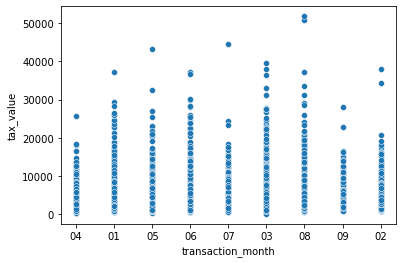

In [33]:
sns.scatterplot(x=train.transaction_month, y=train.tax_value)